# Introduction

In this project I will be implementing an unsupervised approach to news classification.

In [27]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


# EDA and loading data

To start this project I will load the data and do some basic EDA.

In [2]:
train_df = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
test_df = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')

In [3]:
train_df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
test_df.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


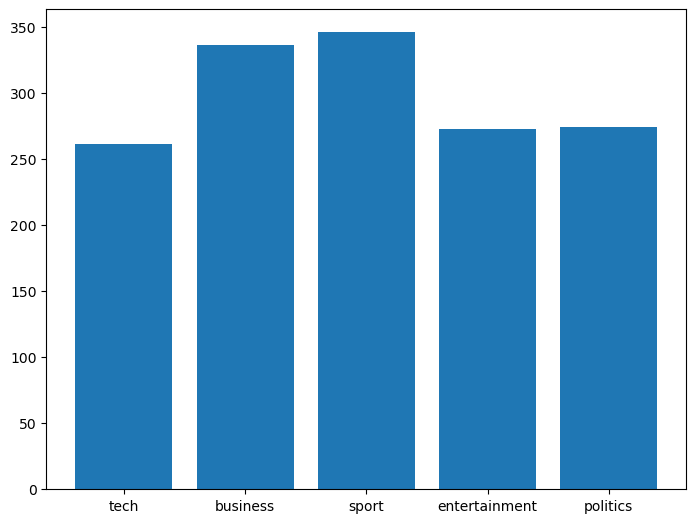

In [5]:
cat_to_int = {
    'tech': 0, 
    'business': 1, 
    'sport': 2, 
    'entertainment': 3, 
    'politics': 4
}

counts = [0]*5

for i in range(len(train_df['Category'])):
    counts[cat_to_int[train_df['Category'].iloc[i]]] += 1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
categories = list(cat_to_int.keys())
ax.bar(categories, counts)
plt.show()

In [6]:
train_df.describe()

,ArticleId
count,1490.000000
mean,1119.696644
std,641.826283
min,2.000000
25%,565.250000
50%,1112.500000
75%,1680.750000
max,2224.000000


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [8]:
print(train_df['Text'].iloc[0])

worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebbe

Here I do some very basic data cleaning and text preprocessing.

In [9]:
def preprocess(df):
    df['Text'] = df['Text'].apply(lambda t: re.sub('[^a-zA-Z ]+', '', t))

In [10]:
preprocess(train_df)

In [11]:
print(train_df['Text'].iloc[0])

worldcom exboss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness  cynthia cooper  worldcom s exhead of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in  her warnings led to the collapse of the firm following the discovery of an bn bn accounting fraud mr ebbers has pleaded not guilty to charges of fraud and conspiracy  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early  and  she said andersen had given a  green light  to the procedures and practices used by worldcom mr ebber s lawyers have said he was u

In [12]:
split = int(len(train_df) * 0.95)
train_x = train_df['Text'].iloc[:split]
val_x = train_df['Text'].iloc[split:]

train_y = train_df['Category'].iloc[:split]
val_y = train_df['Category'].iloc[split:]

# NMF

Here I will use NMF to determine news catergories. First I feed the data into a TF-IDF vectorizer, I then feed that into an NMF algorithm. Then use Logistic Regression to fit the data to the correct labels.

In [13]:
tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(train_x)
val_tfidf = tfidf.fit_transform(val_x)

nmf = NMF(n_components=10)
train_nmf = nmf.fit_transform(train_tfidf)
val_nmf = nmf.fit_transform(val_tfidf)

regression = LogisticRegression()
regression.fit(train_nmf, train_y)

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


LogisticRegression()

# NMF Results

Here we can see that NMF achieved an accuracy of about 92% on the training data. I also have a confusion matrix to better visualize the accuracy.

In [14]:
train_yhat = regression.predict(train_nmf)

train_acc = accuracy_score(train_y, train_yhat)

print(train_acc)

0.9180212014134276


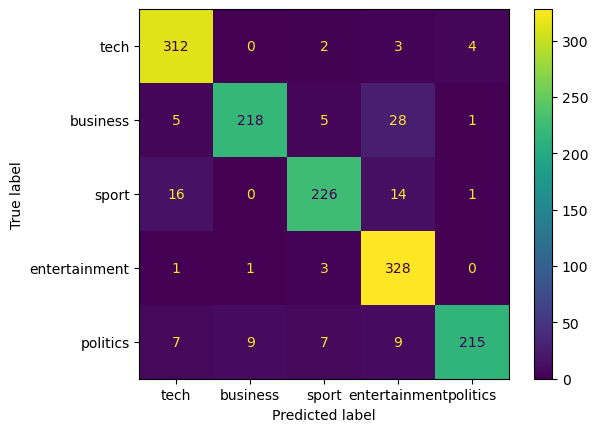

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(train_y, train_yhat)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_to_int.keys())
cm_disp.plot()
plt.show()

# SVM

With this data we can also use SVM's to make predictions. However it is clearly overfitting the data.

In [30]:
svm_classifier = SVC()
svm_classifier.fit(train_tfidf, train_y)

# Prediction
train_yhat = svm_classifier.predict(train_tfidf)

train_acc = accuracy_score(train_y, train_yhat)

print(train_acc)

1.0


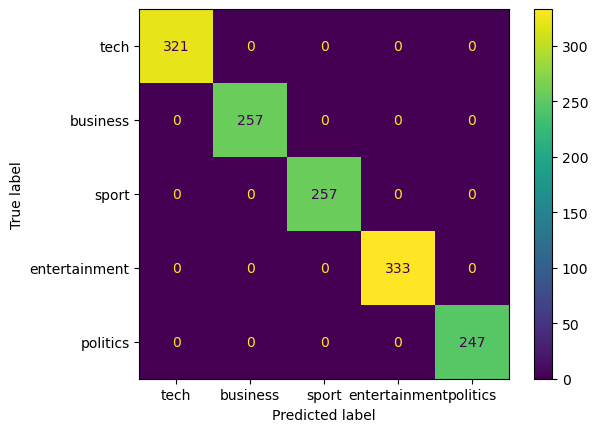

In [23]:
cm = confusion_matrix(train_y, train_yhat)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_to_int.keys())
cm_disp.plot()
plt.show()